In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import scipy
import seaborn as sns
from statsmodels.stats.anova import AnovaRM

import h5py

from tqdm import tqdm

In [2]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [3]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import stat as sstat

In [4]:
import warnings

---

In [5]:
mpl.rcParams['font.family'] = 'Helvetica'

### Font를 못 읽어 온다면, matplotlib 캐시 초기화
`rm -rf ~/.cache/matplotlib`

---

In [6]:
dir_behav = su.get_dir_behav()

In [7]:
list_sn = su.get_list_sn()
list_sn

array(['01', '02', '03', '05', '06', '08', '09', '10', '11', '12', '13',
       '14'], dtype='<U2')

---

## sessions
- ses-1 (S)
- ses-2 (R)

Each session is consist of 8 runs with 68 trials (4 blocks, 17 trials for each block), additional run with long-ISI.
1. The starting trial states are randomly permuted.
2. 5s for each trial (preparation: 1s, movement: 3s, ISI: 1s)
3. Long resting period between blocks (~16 seconds)
4. Each run takes about 7 minutes
5. 17-, 34-, 57-, 64-th trial's ITI are $16000$

## motor sequences
- 32451
- 35124
- 13254
- 14523
## visual cues
- letter
- spatial

---

### (point, isError)
1) (0,0): MT=0 but the response is correct up to that point.
2) (0,1): At some point, the response becomes incorrect.
3) (1,0): A properly conducted trial.

PrepTime(1s) + press(3s) + ITI(1s) = 5s
- $\text{MT} \neq pressTime4 - pressTime0$
- $\text{RT} = pressTime0 - 1000(PrepTime) - (4\text{ or }6)$

## 1. Repetition

 | | symbol | trial$_{t-1}$ | trial $_{t}$ |
 |---------|---------|---------|---------|
 | Both-Rep$_{c}$ <br> (within-$c$ repetition) | <span style="color:#00008B">$B_{c}$</span> | $(s,c)$ | $(s,c)$ |
 | Cue-Rep$_{c}$ <br> (within-$c$ no-repetition) | <span style="color:#0000FF">$C_{c}$</span> | $(\neg s,c)$ | $(s,c)$ |
 | Seq-Rep$_{c}$ <br> (between-$c$ repetition) | <span style="color:#8B0000">$S_{c}$</span> | $(s,\neg c)$ | $(s,c)$ |
 | Non-Rep$_{c}$ <br> (between-$c$ no-repetition) | <span style="color:#FF0000">$N_{c}$</span> | $(\neg s,\neg c)$ | $(s,c)$ |

$Trial State=(s,c)$:\
$ s=0: 32451 $, $ s=1: 35124 $, $s=2: 13254 $, $s=3: 14523$ \
$ c=0: Letter $, $ c=1: Spatial $

In [8]:
dg = pd.DataFrame()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for sess in ['S','R']:
        for sn in tqdm(list_sn):
            subj = sess+sn
            fname = join(dir_behav,'sub-%s/behav_info.tsv'%subj)
            df = pd.read_csv(fname, delimiter='\t')
            df_tmp = df.copy()
    
            df_tmp['ITI-1'] = df.ITI.shift(1)
            df_tmp['cue-1'] = df.cue.shift(1)
            df_tmp['sequence-1'] = df.sequence.shift(1)
            df_tmp['RT-1'] = df.RT.shift(1)
            df_tmp['MT-1'] = df.MT.shift(1)
            
            ## ITI-1 <= 1000 ms
            da = df_tmp[df_tmp['ITI-1']<=1000]
            # df = df[df['isError']==0]
            ## long term trials have no previous trial
            # df_tmp[df_tmp.TN%17==1]['MT-1']=np.nan
            # df_tmp[df_tmp.TN%17==1]['RT-1']=np.nan
    
            da['ITI-1'] = da['ITI-1'].astype(int)
            # da['cue-1'] = da['cue-1'].astype(int)
            da['sequence-1'] = da['sequence-1'].astype(int)
            da['RT-1'] = da['RT-1'].astype(int)
            da['MT-1'] = da['MT-1'].astype(int)
            
            ## default condition = NRep
            da['cond'] = 'Between No-Rep'
            ## other conditions
            da.loc[(da.cue==da['cue-1'])&(da.sequence==da['sequence-1']),'cond'] = 'Within Rep'
            da.loc[(da.cue==da['cue-1'])&(da.sequence!=da['sequence-1']),'cond'] = 'Within No-Rep'
            da.loc[(da.cue!=da['cue-1'])&(da.sequence==da['sequence-1']),'cond'] = 'Between Rep'
            ## subj label
            da['sess']=1 if sess=='S' else(2 if sess=='R' else 0)
            da['subj']=sn
            # df['x'] = ['%s_%d'%(cue,ses) for cue,ses in zip(df['cue'], df['sess'])]
            da['Seq_Rep']=[False if 'No-' in cond else True for cond in da.cond]
            da['Cue_Rep']=['Within' if 'Within' in cond else 'Between' for cond in da.cond]
            ## 수행한 total trial number
            # df['trial']=(df.BN-1)*64+df.TN
            ## remove unncessary rows
            # df = df[df.TN%17 != 1]

            dg = pd.concat([dg,da])

100%|███████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.96it/s]


In [9]:
# dg['cond'] = dg.cond.replace({
#     'Both-Rep':'Within Rep', 'Cue-Rep':'Within No-Rep',
#     'Seq-Rep':'Between Rep', 'Non-Rep':'Between No-Rep'
# })
dg = dg[['sess','subj','BN','TN','cue','sequence','cond','Seq_Rep','Cue_Rep','isError','MT','RT']]
dg

,sess,subj,BN,TN,cue,sequence,cond,Seq_Rep,Cue_Rep,isError,MT,RT
1,1,01,1,2,S,4,Within No-Rep,False,Within,0,1720,382
2,1,01,1,3,L,4,Between Rep,True,Between,0,2056,438
3,1,01,1,4,L,2,Within No-Rep,False,Within,0,1528,478
4,1,01,1,5,S,1,Between No-Rep,False,Between,0,1308,408
5,1,01,1,6,L,2,Between No-Rep,False,Between,0,1776,446
...,...,...,...,...,...,...,...,...,...,...,...,...
539,2,14,8,64,L,3,Within No-Rep,False,Within,0,1022,346
540,2,14,8,65,L,1,Within No-Rep,False,Within,0,1054,366
541,2,14,8,66,L,4,Within No-Rep,False,Within,0,1014,526
542,2,14,8,67,L,1,Within No-Rep,False,Within,0,1028,328


In [10]:
## the number of conditions
conds = dg.cond.unique()
for subj in list_sn:
    for ii, sess in enumerate([1,2]):
        tmp = dg[(dg.subj==subj)&(dg.sess==sess)]
        for cond in dg.cond.unique():
            print(subj, sess, cond, len(tmp[tmp.cond==cond]))
        if ii==0:
            print('--------------------------')
    print('==========================')

01 1 Within No-Rep 192
01 1 Between Rep 64
01 1 Between No-Rep 192
01 1 Within Rep 64
--------------------------
01 2 Within No-Rep 192
01 2 Between Rep 64
01 2 Between No-Rep 192
01 2 Within Rep 64
02 1 Within No-Rep 192
02 1 Between Rep 64
02 1 Between No-Rep 192
02 1 Within Rep 64
--------------------------
02 2 Within No-Rep 192
02 2 Between Rep 64
02 2 Between No-Rep 192
02 2 Within Rep 64
03 1 Within No-Rep 192
03 1 Between Rep 64
03 1 Between No-Rep 192
03 1 Within Rep 64
--------------------------
03 2 Within No-Rep 192
03 2 Between Rep 64
03 2 Between No-Rep 192
03 2 Within Rep 64
05 1 Within No-Rep 192
05 1 Between Rep 64
05 1 Between No-Rep 192
05 1 Within Rep 64
--------------------------
05 2 Within No-Rep 192
05 2 Between Rep 64
05 2 Between No-Rep 192
05 2 Within Rep 64
06 1 Within No-Rep 192
06 1 Between Rep 64
06 1 Between No-Rep 192
06 1 Within Rep 64
--------------------------
06 2 Within No-Rep 192
06 2 Between Rep 64
06 2 Between No-Rep 192
06 2 Within Rep 64
08 1 

---
---

### 학습이 일어났는가?

In [12]:
## invalid trial들은 제거 후 Block마다 within subject 평균
dh = dg[dg.isError==0].groupby(['sess','subj','BN'])[['MT','RT']].median().reset_index()
dh

,sess,subj,BN,MT,RT
0,1,01,1,1716.0,434.0
1,1,01,2,1855.0,416.0
2,1,01,3,1882.0,402.0
3,1,01,4,1810.0,406.0
4,1,01,5,1890.0,412.0
...,...,...,...,...,...
187,2,14,4,918.0,334.0
188,2,14,5,968.0,345.0
189,2,14,6,1150.0,328.0
190,2,14,7,1081.0,342.0


MT
RT


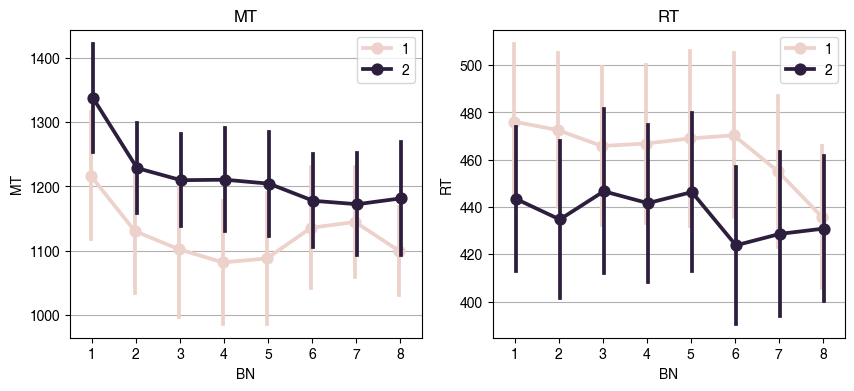

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, value in enumerate(['MT','RT']):
    print(value)
    ax = axs[ii]
    g = sns.pointplot(
        data=dh,
        x='BN', y=value, hue='sess',
        estimator='mean',
        errorbar='se', dodge=True,
        ax=ax
    )
    g.set_title(value)
    g.legend()
    g.grid(axis='y')

    # for sess in ['S','R']:
    #     tmp = dh[(dh.sess==sess)].set_index('subj', drop=False)
    #     a = tmp[tmp.BN==1][value].astype(float)
    #     b = tmp[tmp.BN==2][value].astype(float)
    #     res = scipy.stats.ttest_rel(a=a, b=b, alternative='two-sided')
    #     print(sess, 't(%d)=%.4f (%s)'%(res.df, res.statistic, sstat.convert_pval_to_star(res.pvalue)))

### 
---
---

In [11]:
def get_df_groupby(df=dg, by=['sess','subj','cue','cond'], successed=True, estimate='mean'):
    if successed:
        dg = df[df.isError==0]
    else:
        dg = df

    if estimate=='mean':
        dg_groupby = dg.groupby(by)[['isError','MT','RT']].mean().reset_index()
    elif estimate=='median':
        dg_groupby = dg.groupby(by)[['isError','MT','RT']].median().reset_index()    
    return dg_groupby

In [12]:
estimate = 'median'

In [13]:
dg_groupby = get_df_groupby(df=dg, by=['subj','Cue_Rep','Seq_Rep'], successed=True, estimate=estimate)
dg_groupby

,subj,Cue_Rep,Seq_Rep,isError,MT,RT
0,01,Between,False,0.0,1584.0,368.0
1,01,Between,True,0.0,1610.0,372.0
2,01,Within,False,0.0,1622.0,368.0
3,01,Within,True,0.0,1586.0,364.0
4,02,Between,False,0.0,1116.0,356.0
5,02,Between,True,0.0,1143.0,350.0
6,02,Within,False,0.0,1092.0,346.0
7,02,Within,True,0.0,1129.0,354.0
8,03,Between,False,0.0,1189.0,420.0
9,03,Between,True,0.0,1198.0,426.0


In [14]:
hue_order = [True,False]
order = ['Within','Between']
palette = ['#27afaf','#af2727']

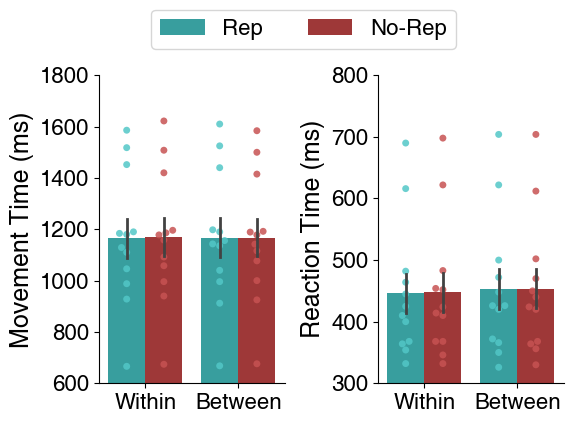

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

for ii, feature in enumerate(['MT','RT']):
    ax = axs[ii]
    sns.swarmplot(
        data=dg_groupby,
        x='Cue_Rep', order=order,
        y=feature,
        hue='Seq_Rep', hue_order=hue_order, dodge=True,
        edgecolor='black',
        palette=['#52c7c7','#c75252'], alpha=0.85,
        ax=ax, zorder=2
    )
    g = sns.barplot(
        data=dg_groupby,
        x='Cue_Rep', order=order,
        y=feature, estimator='mean',
        hue='Seq_Rep', hue_order=hue_order,
        errorbar='se', capsize=0., err_kws={'linewidth': 2.0},
        palette=palette,
        ax=ax, zorder=1
    )
    handles, labels = g.get_legend_handles_labels()
    ax.legend().remove()
    
#     # g.grid(axis='y')
    if ii == 0:
        ylabel = 'Movement Time (ms)'
        g.set_ylim(600,1700)
        g.legend(
            handles[2:], ['Rep','No-Rep'],
            loc='lower center', bbox_to_anchor=(1.1, 1.05),
            ncol=2, fontsize=16
        )
    elif ii == 1:
        ylabel = 'Reaction Time (ms)'
        g.set_ylim(300,800)
    g.set_ylabel(ylabel, fontsize=18)

    g.set_xlabel('')
    xticks = g.get_xticks()
    g.set_xticks(xticks)
    xticklabels = g.get_xticklabels()
    g.set_xticklabels(xticklabels, fontsize=16)
    # g.set_ylabel(ylabel,fontsize=20)
    yticks = g.get_yticks().astype(int)
    g.set_yticks(yticks)
    g.set_yticklabels(yticks, fontsize=16)
#     # g.set_title('session %s'%sess,fontsize=16)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

plt.subplots_adjust(wspace=0.5)
# # fig.tight_layout()

In [16]:
fig.savefig(
    join('/mnt/f/SeqSpatialSupp_fMRI/behav.png'),
    dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

### Removed

In [17]:
# hue_order = ['Within Rep','Within No-Rep','Between Rep','Between No-Rep']
# order = ['L','S']
# palette = ['#191970','#89CFF0','#800020','#F08080']
# # palette = ['#191970','#800020']

In [16]:
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

# for ii, feature in enumerate(['MT','RT']):
#     ax = axs[ii]
#     g = sns.barplot(
#         data=dg_groupby,
#         x='cue', order=order,
#         y=feature, estimator='mean',
#         hue='cond', hue_order=hue_order,
#         errorbar='se', capsize=0.15, dodge=True,
#         palette=palette,
#         ax=ax
#     )
#     # g = sns.swarmplot(
#     #     data=dg_groupby,
#     #     x='x', order=order,
#     #     y=feature,
#     #     hue='cond', hue_order=hue_order, dodge=True,
#     #     edgecolor='black',
#     #     palette=['#6A6AB8','#B3E4F9','#FFFFFF','#C08090','#F5A6A6'],
#     #     ax=ax
#     # )
#     handles, labels = ax.get_legend_handles_labels()
#     g.legend().remove()
    
#     # g.grid(axis='y')
#     if ii == 0:
#         ylabel = 'Movement Time (ms)'
#         g.set_ylim(900,1500)
#         g.legend(
#             handles[:4], labels[:4],
#             loc='lower center', bbox_to_anchor=(1.1, 1.05),
#             ncol=2, fontsize=16
#         )
#     elif ii == 1:
#         ylabel = 'Reaction Time (ms)'
#         g.set_ylim(350,600)

#     g.set_xlabel('')
#     # xticks = g.get_xticks()
#     g.set_xticks([0,1])
#     g.set_xticklabels(['Letter','Spatial'], fontsize=14)
#     g.set_xlabel('', fontsize=16)
#     yticks = g.get_yticks().astype(int)
#     g.set_ylabel(ylabel,fontsize=20)
#     g.set_yticks(yticks)
#     g.set_yticklabels(yticks, fontsize=16)
#     # g.set_xticklabels(['Letter$_{S}$','Spatial$_{S}$','Letter$_{R}$','Spatial$_{R}$'],fontsize=14)
#     # g.set_title('session %s'%sess,fontsize=16)
#     g.spines['right'].set_visible(False)
#     g.spines['top'].set_visible(False)

# plt.subplots_adjust(wspace=0.5)
# # fig.tight_layout()

In [41]:
# df_groupby = get_df_groupby(df=dg, by=['subj','cue'], successed=True, estimate='mean')
# df_groupby

In [42]:
# color = 'black'
# for ii, value in enumerate(['MT','RT']):
#     ax = axs[ii]
#     ## t-test
#     a = df_groupby[df_groupby.cue=='L'][value].astype(float)
#     b = df_groupby[df_groupby.cue=='S'][value].astype(float)
#     res = scipy.stats.ttest_rel(a,b,alternative='greater')
#     tval = res.statistic
#     pval = res.pvalue
#     print('%s: t(%d)=%.4f (%sp=%.3e)'%(value, res.df, tval, sstat.convert_pval_to_star(pval), pval))
#     print((a.values-b.values).mean(), scipy.stats.sem(a.values-b.values))
#     if pval<0.05:
#         fontsize = 20
#     else:
#         fontsize = 14
    
#     ylim = np.array(ax.get_ylim())
#     ydiff = np.diff(ylim)[0]
#     ymean = ylim.mean()
#     dy = ydiff * 0.05
#     # ax.set_ylim([ymean-ydiff*0.8, ymean+ydiff*0.9])
    
#     x1 = 0
#     y1 = a.mean() + a.sem() + dy*2.5
#     ax.plot([x1-0.25,x1+0.25],[y1,y1],linestyle='-',color=color)
#     x2 = 1
#     y2 = b.mean() + b.sem() + dy*2.5
#     ax.plot([x2-0.25,x2+0.25],[y2,y2],linestyle='-',color=color)
#     yU = max(y1,y2) + dy*3
#     ax.plot([x1,x1],[y1,yU],linestyle='-',color=color)
#     ax.plot([x2,x2],[y2,yU],linestyle='-',color=color)
#     ax.plot([x1,x2],[yU,yU],linestyle='-',color=color)
#     ax.text(
#         (x1+x2)*0.5, yU+dy,
#         sstat.convert_pval_to_star(pval), fontsize=fontsize, color=color,
#         ha='center', va='center'
#     )
# fig.subplots_adjust(wspace=0.4)
# fig

## ANOVA

In [17]:
df = get_df_groupby(df=dg, by=['subj','cue','Cue_Rep','Seq_Rep'], successed=True, estimate=estimate)
df

,subj,cue,Cue_Rep,Seq_Rep,isError,MT,RT
0,01,L,Between,False,0.0,1592.0,366.0
1,01,L,Between,True,0.0,1653.0,396.0
2,01,L,Within,False,0.0,1660.0,392.0
3,01,L,Within,True,0.0,1616.0,366.0
4,01,S,Between,False,0.0,1572.0,370.0
...,...,...,...,...,...,...,...
91,14,L,Within,True,0.0,976.0,339.0
92,14,S,Between,False,0.0,998.0,326.0
93,14,S,Between,True,0.0,981.0,322.0
94,14,S,Within,False,0.0,992.0,326.0


In [18]:
for value in ['MT','RT']:
    print(value)
    for ccond in ['Within','Between']:
        print(ccond)
        aov = AnovaRM(
            data=df[df.Cue_Rep==ccond],
            depvar=value,
            subject='subj',
            within=['cue','Seq_Rep']
        ).fit()
        print(aov)

MT
Within
                  Anova
            F Value Num DF  Den DF Pr > F
-----------------------------------------
cue          4.4321 1.0000 11.0000 0.0591
Seq_Rep      0.8118 1.0000 11.0000 0.3869
cue:Seq_Rep  0.0692 1.0000 11.0000 0.7974

Between
                  Anova
            F Value Num DF  Den DF Pr > F
-----------------------------------------
cue          5.6505 1.0000 11.0000 0.0367
Seq_Rep      0.0221 1.0000 11.0000 0.8846
cue:Seq_Rep  0.1588 1.0000 11.0000 0.6979

RT
Within
                  Anova
            F Value Num DF  Den DF Pr > F
-----------------------------------------
cue          8.9447 1.0000 11.0000 0.0123
Seq_Rep      2.2717 1.0000 11.0000 0.1599
cue:Seq_Rep  4.7180 1.0000 11.0000 0.0526

Between
                  Anova
            F Value Num DF  Den DF Pr > F
-----------------------------------------
cue          0.1216 1.0000 11.0000 0.7339
Seq_Rep      0.2929 1.0000 11.0000 0.5992
cue:Seq_Rep  2.0318 1.0000 11.0000 0.1818



## paired t-test (Rep vs. No-Rep)

#### i) Comparing different cues

In [19]:
df = get_df_groupby(df=dg, by=['subj','cue'], successed=True, estimate=estimate)
df

,subj,cue,isError,MT,RT
0,01,L,0.0,1626.0,378.0
1,01,S,0.0,1571.0,360.0
2,02,L,0.0,1141.0,358.0
3,02,S,0.0,1083.0,348.0
4,03,L,0.0,1202.0,410.0
5,03,S,0.0,1180.0,426.0
6,05,L,0.0,1142.0,420.0
7,05,S,0.0,1140.0,412.0
8,06,L,0.0,1182.0,702.0
9,06,S,0.0,1176.0,700.0


In [20]:
for value in ['MT','RT']:
    print(value)
    a = df[df.cue=='S'][value].astype(float)
    b = df[df.cue=='L'][value].astype(float)
    tmp = a.values-b.values
    print(tmp.mean(), scipy.stats.sem(tmp))
    res = scipy.stats.ttest_rel(a,b,alternative='two-sided')
    tval = res.statistic
    pval = res.pvalue
    print('t(%d)=%.4f (%sp=%.3e)'%(res.df, tval, sstat.convert_pval_to_star(pval), pval))

MT
-18.75 6.420994211698581
t(11)=-2.9201 (*p=1.393e-02)
RT
-5.416666666666667 3.738534661353485
t(11)=-1.4489 (nsp=1.753e-01)


## paired t-test (Sess-1 vs. Sess-2)

#### ii) Differences across session

In [21]:
df = get_df_groupby(df=dg, by=['subj','sess'], successed=False, estimate='mean')
df

,subj,sess,isError,MT,RT
0,01,1,0.060547,1786.621094,411.660156
1,01,2,0.048828,1464.187500,351.402344
2,02,1,0.007812,1030.937500,372.644531
3,02,2,0.011719,1233.988281,366.257812
4,03,1,0.023438,1036.121094,441.027344
5,03,2,0.017578,1220.648438,416.824219
6,05,1,0.019531,1095.238281,424.691406
7,05,2,0.003906,1323.410156,429.746094
8,06,1,0.029297,1049.789062,736.394531
9,06,2,0.001953,1312.699219,678.117188


t(11)=2.5376 (*p=1.380e-02)


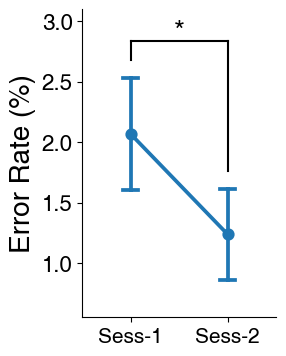

In [28]:
fig, ax = plt.subplots(figsize=(2.5,4))
g = sns.pointplot(
    data = df,
    x='sess', order=[1,2],
    y='isError',
    errorbar='se', capsize=0.15,
    ax=ax
)
# g.grid(axis='y')
g.set_xlabel('')
g.set_xticks([0,1])
g.set_xticklabels(['Sess-1','Sess-2'], fontsize=15)
g.set_xlim(-0.5,1.5)
g.set_ylabel('Error Rate (%)', fontsize=20)
# yticks = g.get_yticks()
yticks = np.arange(0.005,0.035,0.005)
g.set_yticks(yticks)
g.set_yticklabels(['%.01f'%(y*100) for y in yticks], fontsize=16)
g.set_ylim(0.01,0.025)
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

## t-test
a = df[df.sess==1]['isError'].astype(float)
b = df[df.sess==2]['isError'].astype(float)
res = scipy.stats.ttest_rel(a,b,alternative='greater')
tval = res.statistic
pval = res.pvalue
print('t(%d)=%.4f (%sp=%.3e)'%(res.df, tval, sstat.convert_pval_to_star(pval), pval))

ylim = np.array(g.get_ylim())
ydiff = np.diff(ylim)[0]
ymean = ylim.mean()
dy = ydiff * 0.05
g.set_ylim([ymean-ydiff*0.8, ymean+ydiff*0.9])
if pval < 0.05:
    x1 = 0
    x2 = 1
    y1 = a.mean() + a.sem() + 2*dy
    y2 = b.mean() + b.sem() + 2*dy
    yU = max(y1,y2) + dy*2
    color = 'black'
    g.plot([x1,x1],[y1,yU],linestyle='-',color=color)
    g.plot([x2,x2],[y2,yU],linestyle='-',color=color)
    g.plot([x1,x2],[yU,yU],linestyle='-',color=color)
    g.text(
        (x1+x2)*0.5, yU+dy,
        sstat.convert_pval_to_star(pval), fontsize=20, color=color,
        ha='center', va='center'
    )

In [29]:
fig.savefig(
    join('/mnt/f/SeqSpatialSupp_fMRI/error.png'),
    dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

#### iii) Repetition advantage

In [33]:
dg['cond_'] = ['Between' if 'Between' in cond else('Within' if 'Within' in cond else 'invalid') for cond in dg.cond]
dg_groupby = dg[dg.isError==0].groupby(['sess','subj','cond_'])[['isError','MT','RT']].mean().reset_index()

In [34]:
dg_groupby

,sess,subj,cond_,isError,MT,RT
0,1,01,Between,0.0,1810.775862,417.293103
1,1,01,Within,0.0,1782.849315,405.360731
2,1,02,Between,0.0,1029.805085,375.500000
3,1,02,Within,0.0,1028.325000,373.091667
4,1,03,Between,0.0,1033.327586,448.844828
5,1,03,Within,0.0,1039.130802,429.814346
6,1,05,Between,0.0,1094.903766,432.410042
7,1,05,Within,0.0,1083.696970,418.337662
8,1,06,Between,0.0,1041.626087,737.043478
9,1,06,Within,0.0,1052.312236,732.616034


In [40]:
tmp = dg_groupby[dg_groupby.sess==1]
a = tmp[tmp.cond_=='Between'].RT.astype(float)
b = tmp[tmp.cond_=='Within'].RT.astype(float)
res = scipy.stats.ttest_rel(a,b,alternative='greater')
tval = res.statistic
pval = res.pvalue
print('t(%d)=%.4f (%sp=%.3e)'%(res.df, tval, sstat.convert_pval_to_star(pval), pval))

t(11)=2.9106 (**p=7.086e-03)


---
---

### 어떤 Seq가 어려웠나?

In [89]:
sess = 'S'

In [90]:
df = pd.DataFrame()
for sn in list_sn:
    subj = sess+sn
    fname = join(dir_behav,'sub-%s/ssh__%s.dat'%(subj,subj))
    df_tmp = pd.read_csv(fname, delimiter='\t')
    df_tmp = df_tmp[['BN','TN','seqType','cueP','MT','RT','points','isError']]
    
    ## 각 run의 가장 마지막 trial은 제외
    # df = df[df.iti<2000]

    ## 9번째 run (long ITI)은 제거
    df_tmp = df_tmp[df_tmp.BN < 9]

    ## 성공적으로 수행한 trial들만 고려
    # df_tmp = df_tmp[df_tmp.points == 1]
    df_tmp = df_tmp[df_tmp.isError == 0]

    df_tmp.seqType = ['Letter' if i==0 else 'Spatial' for i in df_tmp.seqType]
    df_tmp.cueP = df_tmp.cueP.astype('str')

    df_tmp['subj'] = subj
    # df_tmp['hue'] = ['%s_%s'%(seq,ses) for seq,ses in zip(df_tmp.seqType,df_tmp.sess)]

    df = pd.concat([df,df_tmp])

df.rename(columns={'seqType':'cue', 'cueP':'seq'}, inplace=True)
df['cue'] = df.cue.replace({'Letter':'L', 'Spatial':'S'})
df

,BN,TN,cue,seq,MT,RT,points,isError,subj
0,1,1,S,35124,1680,566,1,0,S01
1,1,2,S,14523,1720,382,1,0,S01
2,1,3,L,14523,2056,438,1,0,S01
3,1,4,L,35124,1528,478,1,0,S01
4,1,5,S,32451,1308,408,1,0,S01
...,...,...,...,...,...,...,...,...,...
539,8,64,S,32451,796,436,1,0,S14
540,8,65,L,32451,790,404,1,0,S14
541,8,66,S,32451,832,246,1,0,S14
542,8,67,L,14523,816,400,1,0,S14


In [91]:
df_groupby = df.groupby(['subj','cue','seq'])[['MT','RT']].mean().reset_index()
df_groupby

,subj,cue,seq,MT,RT
0,S01,L,13254,1740.716418,435.940299
1,S01,L,14523,1927.096774,410.451613
2,S01,L,32451,1756.062500,438.656250
3,S01,L,35124,1728.212121,440.303030
4,S01,S,13254,1668.707692,407.138462
...,...,...,...,...,...
91,S14,L,35124,938.656716,368.358209
92,S14,S,13254,937.384615,349.384615
93,S14,S,14523,958.477612,337.910448
94,S14,S,32451,974.176471,320.911765


In [92]:
list_seq = ['32451','35124','13254','14523']

MT
32451
t(11)=2.1735, nsp=0.0525
35124
t(11)=0.1990, nsp=0.8459
13254
t(11)=1.6369, nsp=0.1299
14523
t(11)=0.4050, nsp=0.6932
RT
32451
t(11)=5.7743, ***p=0.0001
35124
t(11)=3.3537, **p=0.0064
13254
t(11)=0.9114, nsp=0.3816
14523
t(11)=0.5741, nsp=0.5774


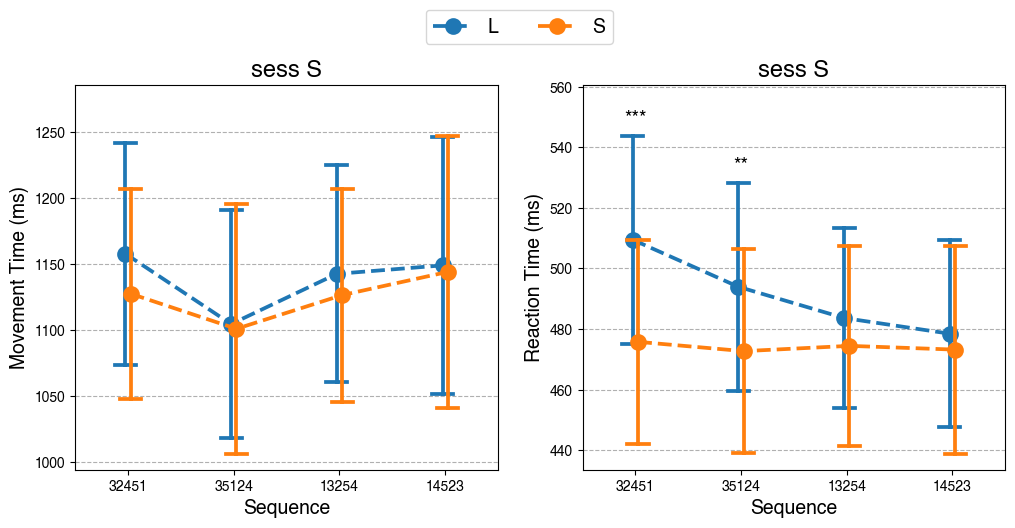

In [93]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

hue = 'cue'
# hue = 'sess'
for ii, feature in enumerate(['MT','RT']):
    print(feature)
    ax = axs[ii]
    g = sns.pointplot(
        data=df_groupby,
        x='seq', order=list_seq, y=feature, hue=hue,
        linestyles='--', markers=['o','o'], markersize=10,
        errorbar='se', capsize=0.2, dodge=True,
        ax=ax
    )
    g.grid(axis='y', linestyle='--')
    if ii==0:
        g.legend(loc='center', bbox_to_anchor=(1.05, 1.15), ncol=2, fontsize=14)
    else:
        g.legend().remove()
    g.set_xlabel('Sequence', fontsize=14)
    ylabel = 'Movement Time (ms)' if feature=='MT' else 'Reaction Time (ms)'
    g.set_ylabel(ylabel, fontsize=14)
    g.set_title('sess %s'%sess, fontsize=17)
    ya, yb = g.get_ylim()
    dy = (yb-ya) * 0.05

    ## t-test
    for ss, seq in enumerate(list_seq):
        print(seq)
        a = df_groupby[(df_groupby.cue=='L')&(df_groupby.seq==seq)][feature].astype(float)
        b = df_groupby[(df_groupby.cue=='S')&(df_groupby.seq==seq)][feature].astype(float)
        res = scipy.stats.ttest_rel(a,b)
        tval, pval = res
        dof = res.df
        print('t(%d)=%.4f, %sp=%.4f'%(dof,tval,sstat.convert_pval_to_star(pval),pval))
        
        if pval < 0.05:
            x = ss # + 0.2*(cc-1.5)
            y1 = a.mean()+a.sem()
            y2 = b.mean()+b.sem()
            y = max(y1,y2) + dy
            
            g.text(
                x, y,
                sstat.convert_pval_to_star(pval), fontsize=14, color='black',
                ha='center', va='center',
            )
    g.set_ylim(ya,yb+dy*2)

-> Spatial Cue의 경우 직관적이므로, 반응시간(RT)과 입력시간(MT) 모두 단축되었으며, sequence에 관계없이 비슷한 시간들을 나타낸다.

-> 첫 손가락이 '3'인 경우 입력 속도가 느림 (RT$\uparrow$)

---
---

In [30]:
# fig.savefig(
#     join(dir_work,'results/fig.behav.Rep.barplot.png'),
#     dpi=300, facecolor=[1,1,1,1],
#     bbox_inches='tight'
# )

### 왜 session R에서 MT가 더 높은가?
- 단순히 더 정확히 하기 위해서 느려진 것이 아닌가?

In [18]:
palette = ['#4a83d1','#d1984a']

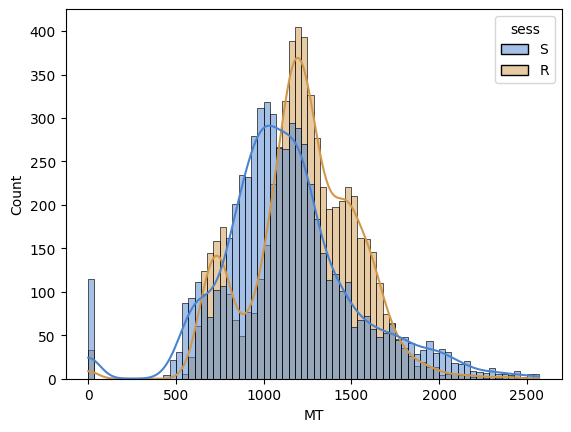

In [19]:
g = sns.histplot(
    data=dg,
    x='MT',
    hue='sess', palette=palette, kde=True,
    alpha=0.5
)
# g.legend()

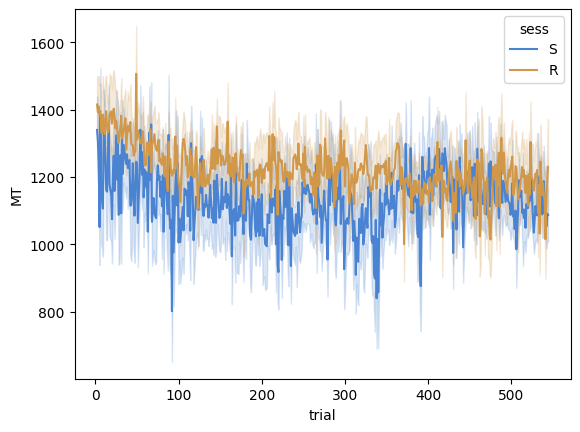

In [20]:
g = sns.lineplot(
    data=dg,
    x='trial', y='MT',
    hue='sess', palette=palette,
    errorbar='se', err_style='band'
)

-> 실험 초반에 느리게 함. 정확성을 위해서가 맞는 듯.

---